In [13]:
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon, Point, LineString
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import os

In [37]:
# Путь к директории с данными
data_dir = "C:\\Users\\hedge\\DataspellProjects\\cp_2024_graphs\\Векторные данные\\"

# Функция для загрузки и приведения к нужной CRS
def load_and_reproject(file_path, target_crs="EPSG:3857"):
    try:
        gdf = gpd.read_file(file_path)
        gdf = gdf.to_crs(target_crs)
        print(f"Файл {file_path} загружен успешно с {len(gdf)} записями.")
        return gdf
    except Exception as e:
        print(f"Ошибка при загрузке файла {file_path}: {e}")
        return None

# Загрузка данных
houses1 = load_and_reproject(os.path.join(data_dir, "House_1очередь_ЖК.shp"))
houses2 = load_and_reproject(os.path.join(data_dir, "House_2очередь_ЖК.shp"))
houses3 = load_and_reproject(os.path.join(data_dir, "House_3очередь_ЖК.shp"))
streets1 = load_and_reproject(os.path.join(data_dir, "Streets_1очередь.shp"))
streets2 = load_and_reproject(os.path.join(data_dir, "Streets_2очередь.shp"))
streets3 = load_and_reproject(os.path.join(data_dir, "Streets_3очередь.shp"))
streets_orig = load_and_reproject(os.path.join(data_dir, "Streets_исходные.shp"))
metro_exits = load_and_reproject(os.path.join(data_dir, "Выходы_метро.shp"))
bus_stops = load_and_reproject(os.path.join(data_dir, "Остановки_ОТ.shp"))
houses_orig = load_and_reproject(os.path.join(data_dir, "Дома_исходные.shp"))

Файл C:\Users\hedge\DataspellProjects\cp_2024_graphs\Векторные данные\House_1очередь_ЖК.shp загружен успешно с 45 записями.
Файл C:\Users\hedge\DataspellProjects\cp_2024_graphs\Векторные данные\House_2очередь_ЖК.shp загружен успешно с 126 записями.
Файл C:\Users\hedge\DataspellProjects\cp_2024_graphs\Векторные данные\House_3очередь_ЖК.shp загружен успешно с 3 записями.
Файл C:\Users\hedge\DataspellProjects\cp_2024_graphs\Векторные данные\Streets_1очередь.shp загружен успешно с 27521 записями.
Файл C:\Users\hedge\DataspellProjects\cp_2024_graphs\Векторные данные\Streets_2очередь.shp загружен успешно с 28069 записями.
Файл C:\Users\hedge\DataspellProjects\cp_2024_graphs\Векторные данные\Streets_3очередь.shp загружен успешно с 28817 записями.
Файл C:\Users\hedge\DataspellProjects\cp_2024_graphs\Векторные данные\Streets_исходные.shp загружен успешно с 27209 записями.
Файл C:\Users\hedge\DataspellProjects\cp_2024_graphs\Векторные данные\Выходы_метро.shp загружен успешно с 7 записями.
Файл C

C:\Users\hedge\DataspellProjects\vklab_recsys\venv\lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: C:\Users\hedge\DataspellProjects\cp_2024_graphs\Векторные данные\Дома_исходные.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


Файл C:\Users\hedge\DataspellProjects\cp_2024_graphs\Векторные данные\Дома_исходные.shp загружен успешно с 16386 записями.


In [38]:
def fix_winding_order(geom):
    """
    Исправляет порядок обхода колец полигона.
    Внешнее кольцо должно обходиться по часовой стрелке (CW),
    внутренние (дыры) — против часовой стрелки (CCW).
    """
    if geom is None:
        return geom

    if isinstance(geom, Polygon):
        exterior = geom.exterior
        interiors = list(geom.interiors)

        # Обеспечиваем, что внешний контур обходится по часовой стрелке
        if exterior.is_ccw:
            exterior = Polygon(exterior.coords[::-1]).exterior

        # Внутренние кольца (дыры) должны обходиться против часовой стрелки
        fixed_interiors = []
        for interior in interiors:
            if not interior.is_ccw:
                fixed_interiors.append(interior.coords[::-1])
            else:
                fixed_interiors.append(interior.coords)

        return Polygon(exterior, fixed_interiors)

    elif isinstance(geom, MultiPolygon):
        fixed_polygons = [fix_winding_order(p) for p in geom.geoms]
        return MultiPolygon(fixed_polygons)

    else:
        return geom

def safe_fix_winding_order(geom):
    """
    Безопасно применяет функцию исправления порядка обхода.
    В случае ошибки возвращает исходную геометрию.
    """
    try:
        return fix_winding_order(geom)
    except Exception as e:
        print(f"Ошибка при обработке геометрии: {e}")
        return geom

def further_fix_geometry(gdf):
    """
    Дополнительное исправление геометрий с помощью buffer(0).
    """
    gdf['geometry'] = gdf['geometry'].buffer(0)
    return gdf

In [39]:
# Применение функции исправления порядка обхода
houses_orig['geometry'] = houses_orig['geometry'].apply(safe_fix_winding_order)

# Проверка корректности геометрий
invalid_geometries = houses_orig[~houses_orig.is_valid]
print(f"Количество некорректных геометрий после исправления: {len(invalid_geometries)}")

if not invalid_geometries.empty:
    print("Некорректные геометрии найдены:")
    print(invalid_geometries[['Name', 'Type', 'Purpose', 'geometry']].head())
else:
    print("Все геометрии корректны.")

Количество некорректных геометрий после исправления: 527
Некорректные геометрии найдены:
     Name        Type    Purpose  \
2    None  Жилые дома  Жилой дом   
203  None  Жилые дома  Жилой дом   
204  None  Жилые дома  Жилой дом   
205  None  Жилые дома  Жилой дом   
207  None  Жилые дома  Жилой дом   

                                              geometry  
2    MULTIPOLYGON (((4168473.52 7465603.51, 4168486...  
203  MULTIPOLYGON (((4171456.38 7483279.58, 4171437...  
204  MULTIPOLYGON (((4171051.98 7483211.1, 4171201....  
205  MULTIPOLYGON (((4171529.31 7483463.04, 4171519...  
207  MULTIPOLYGON (((4171663.79 7483309.12, 4171643...  


In [40]:
if not invalid_geometries.empty:
    # Применение buffer(0) для дополнительного исправления
    houses_orig = further_fix_geometry(houses_orig)

    # Повторная проверка корректности геометрий
    invalid_geometries = houses_orig[~houses_orig.is_valid]
    print(f"Количество некорректных геометрий после дополнительного исправления: {len(invalid_geometries)}")

    if not invalid_geometries.empty:
        print("Некорректные геометрии после дополнительного исправления:")
        print(invalid_geometries[['Name', 'Type', 'Purpose', 'geometry']].head())
    else:
        print("Все геометрии корректны после дополнительного исправления.")

Количество некорректных геометрий после дополнительного исправления: 0
Все геометрии корректны после дополнительного исправления.


In [41]:
# Создание пустого графа
G = nx.Graph()

def add_streets_to_graph(streets_gdf, graph):
    """
    Добавляет улицы из GeoDataFrame в граф.
    """
    for idx, row in streets_gdf.iterrows():
        geometry = row['geometry']
        if isinstance(geometry, LineString):
            coords = list(geometry.coords)
            for i in range(len(coords)-1):
                u = coords[i]
                v = coords[i+1]
                length = Point(u).distance(Point(v))  # Расстояние между узлами
                # Добавляем ребро с весом
                if graph.has_edge(u, v):
                    # Если ребро уже существует, сохраняем минимальный вес
                    if length < graph[u][v]['weight']:
                        graph[u][v]['weight'] = length
                else:
                    graph.add_edge(u, v, weight=length)
        elif isinstance(geometry, MultiPolygon):
            # Обычно улицы представлены LineString, но на всякий случай
            continue
    return graph

# Объединение всех данных улиц
streets_combined = pd.concat([streets_orig, streets1, streets2, streets3], ignore_index=True)

# Добавление улиц в граф
G = add_streets_to_graph(streets_combined, G)

print(f"Граф дорожной сети создан с {G.number_of_nodes()} узлами и {G.number_of_edges()} ребрами.")

Граф дорожной сети создан с 59409 узлами и 67145 ребрами.


In [42]:
# Получение списка связанных компонентов, отсортированных по размеру
connected_components = list(nx.connected_components(G))
connected_components = sorted(connected_components, key=len, reverse=True)

print(f"Количество связанных компонентов в графе: {len(connected_components)}")

# Вывод размера каждого компонента
for i, component in enumerate(connected_components, 1):
    print(f"Компонент {i}: {len(component)} узлов")

# Выбор самого большого компонента
largest_component = connected_components[0]
print(f"Размер самого большого компонента: {len(largest_component)} узлов")

# Создание подграфа только с этим компонентом
G_largest = G.subgraph(largest_component).copy()
print(f"Граф с самым большим компонентом имеет {G_largest.number_of_nodes()} узлов и {G_largest.number_of_edges()} ребер.")

# Проверка связности
if nx.is_connected(G_largest):
    print("Граф с самым большим компонентом является связным.")
else:
    print("Граф с самым большим компонентом не является полностью связным.")

Количество связанных компонентов в графе: 12
Компонент 1: 58849 узлов
Компонент 2: 358 узлов
Компонент 3: 83 узлов
Компонент 4: 33 узлов
Компонент 5: 24 узлов
Компонент 6: 21 узлов
Компонент 7: 13 узлов
Компонент 8: 10 узлов
Компонент 9: 8 узлов
Компонент 10: 6 узлов
Компонент 11: 2 узлов
Компонент 12: 2 узлов
Размер самого большого компонента: 58849 узлов
Граф с самым большим компонентом имеет 58849 узлов и 66576 ребер.
Граф с самым большим компонентом является связным.


In [43]:
def nearest_node(G, point):
    """
    Находит ближайший узел в графе G к заданной точке.
    """
    try:
        return min(G.nodes, key=lambda node: point.distance(Point(node)))
    except Exception as e:
        print(f"Ошибка при поиске ближайшего узла: {e}")
        return None

Извлечение координат узлов графа и построение KDTree...
Извлечение координат центроидов домов...
Поиск ближайших узлов для всех домов...
Присвоение ближайших узлов домам...

Количество домов без привязки к узлам графа: 0
Все дома успешно привязаны к ближайшим узлам графа.


C:\Users\hedge\AppData\Local\Temp\ipykernel_4780\3814298834.py:64: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


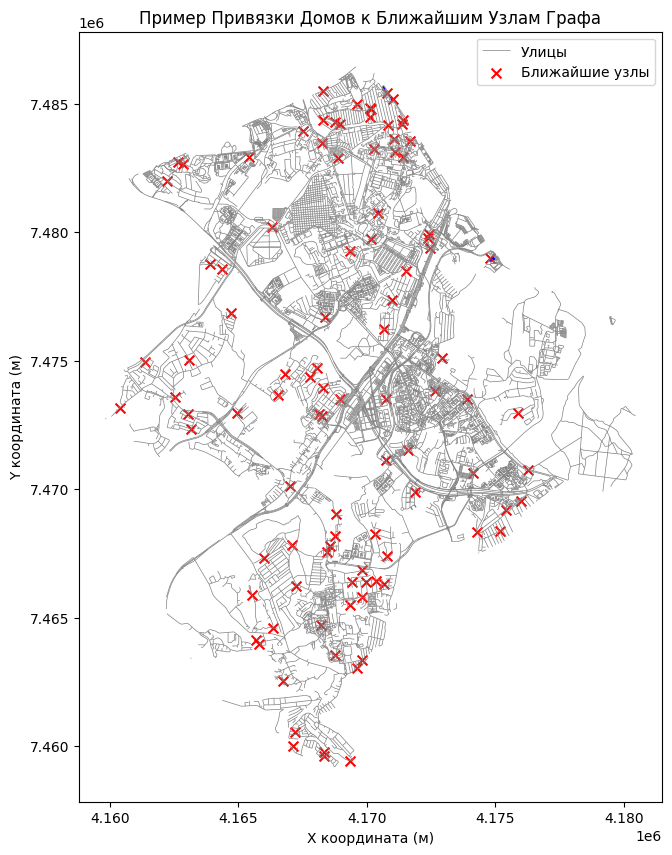

In [47]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
from scipy.spatial import cKDTree
import networkx as nx
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

# Предполагается, что G_largest уже создан и houses_orig загружен и исправлен

# 1. Извлечение координат узлов графа и построение KDTree
print("Извлечение координат узлов графа и построение KDTree...")
nodes = list(G_largest.nodes)
node_coords = np.array(nodes)  # Предполагается, что узлы представлены как (x, y) кортежи

# Создание KDTree
tree = cKDTree(node_coords)

# 2. Извлечение координат центроидов домов
print("Извлечение координат центроидов домов...")
house_centroids = houses_orig.geometry.centroid
house_coords = np.array([(point.x, point.y) for point in house_centroids])

# 3. Поиск ближайших узлов для всех домов одновременно
print("Поиск ближайших узлов для всех домов...")
distances, indices = tree.query(house_coords, k=1)  # k=1 для одного ближайшего соседа

# 4. Присвоение ближайших узлов домам
print("Присвоение ближайших узлов домам...")
houses_orig['nearest_node'] = [nodes[idx] for idx in indices]

# 5. Проверка наличия None (в данном случае не должно быть, так как KDTree всегда находит ближайшего)
missing_nodes = houses_orig['nearest_node'].isna().sum()
print(f"\nКоличество домов без привязки к узлам графа: {missing_nodes}")

if missing_nodes > 0:
    print("Некоторые дома не были привязаны к узлам графа. Рассмотрите возможность удаления или ручной привязки.")
else:
    print("Все дома успешно привязаны к ближайшим узлам графа.")

# Дополнительно: Если необходимо сохранить прогресс, можно использовать tqdm с обработкой по частям
# Однако при использовании KDTree это обычно не требуется, так как операция выполняется быстро

# 6. Визуализация (опционально)
# Пример визуализации нескольких привязанных домов и узлов
num_samples = 100  # Количество домов для визуализации
sample_houses = houses_orig.sample(n=num_samples, random_state=42)

fig, ax = plt.subplots(figsize=(10, 10))

# Визуализация графа
streets_orig.plot(ax=ax, color='gray', linewidth=0.5, label='Улицы')

# Визуализация случайных домов
sample_houses.plot(ax=ax, color='blue', markersize=10, label='Дома')

# Визуализация ближайших узлов
nearest_nodes = pd.DataFrame(sample_houses['nearest_node'].tolist(), columns=['x', 'y'])
nearest_nodes = gpd.GeoDataFrame(nearest_nodes, geometry=gpd.points_from_xy(nearest_nodes.x, nearest_nodes.y), crs="EPSG:3857")
nearest_nodes.plot(ax=ax, color='red', markersize=50, marker='x', label='Ближайшие узлы')

plt.legend()
plt.title("Пример Привязки Домов к Ближайшим Узлам Графа")
plt.xlabel("X координата (м)")
plt.ylabel("Y координата (м)")
plt.show()

# 7. Сохранение Результатов (опционально)
# houses_orig.to_file(os.path.join(data_dir, "Дома_исходные_привязанные.shp"))


Извлечение координат узлов графа и построение KDTree...
KDTree построен успешно.
Фильтрация ключевых точек...
Общее количество ключевых точек перед привязкой: 71
Извлечение координат центроидов ключевых точек...
Поиск ближайших узлов для всех ключевых точек...
Присвоение ближайших узлов ключевым точкам...

Количество ключевых точек без привязки к узлам графа: 0
Все ключевые точки успешно привязаны к ближайшим узлам графа.
Количество ключевых точек после удаления неподключенных: 71


C:\Users\hedge\AppData\Local\Temp\ipykernel_4780\3104782656.py:73: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


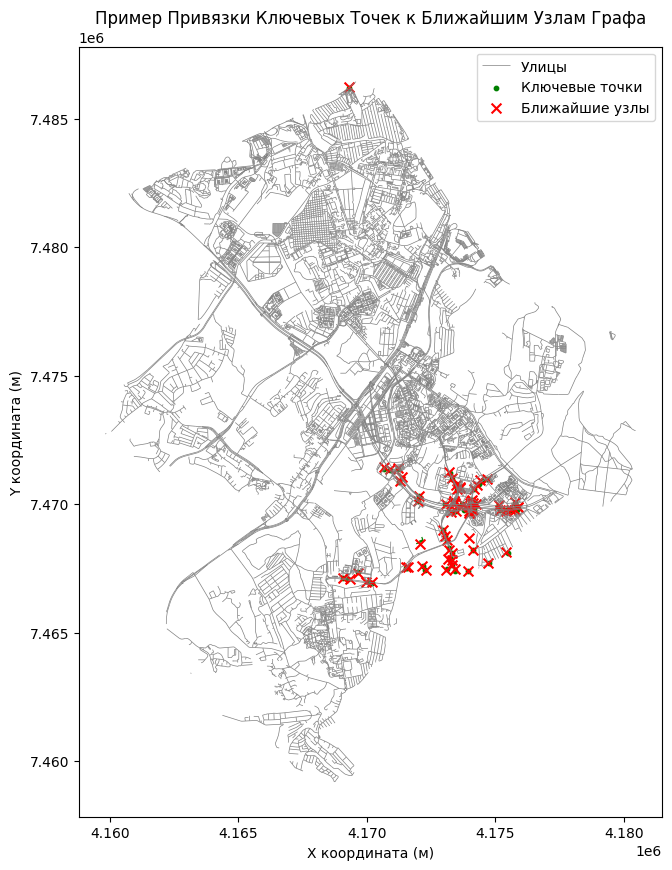

In [50]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point, LineString
from scipy.spatial import cKDTree
import networkx as nx
import matplotlib.pyplot as plt
import os

# Предполагается, что G_largest уже создан и houses_orig загружен и исправлен

# 1. Извлечение координат узлов графа и построение KDTree (если не построен ранее)
print("Извлечение координат узлов графа и построение KDTree...")
nodes = list(G_largest.nodes)
node_coords = np.array(nodes)  # Узлы представлены как (x, y) кортежи

# Создание KDTree
tree = cKDTree(node_coords)
print("KDTree построен успешно.")

# 2. Фильтрация ключевых точек
print("Фильтрация ключевых точек...")
schools = houses3[houses3['Type'] == 'Школы']
key_points = pd.concat([metro_exits, bus_stops, schools], ignore_index=True)
key_points = key_points.to_crs("EPSG:3857")  # Убедитесь, что CRS совпадает

print(f"Общее количество ключевых точек перед привязкой: {len(key_points)}")

# 3. Извлечение координат центроидов ключевых точек
print("Извлечение координат центроидов ключевых точек...")
key_centroids = key_points.geometry.centroid
key_coords = np.array([(point.x, point.y) for point in key_centroids])

# 4. Поиск ближайших узлов для всех ключевых точек одновременно
print("Поиск ближайших узлов для всех ключевых точек...")
distances, indices = tree.query(key_coords, k=1)  # k=1 для одного ближайшего соседа

# 5. Присвоение ближайших узлов ключевым точкам
print("Присвоение ближайших узлов ключевым точкам...")
key_points['nearest_node'] = [nodes[idx] for idx in indices]

# 6. Проверка наличия None (в данном случае не должно быть, так как KDTree всегда находит ближайшего)
missing_key_nodes = key_points['nearest_node'].isna().sum()
print(f"\nКоличество ключевых точек без привязки к узлам графа: {missing_key_nodes}")

if missing_key_nodes > 0:
    print("Некоторые ключевые точки не были привязаны к узлам графа. Рассмотрите возможность удаления или ручной привязки.")
else:
    print("Все ключевые точки успешно привязаны к ближайшим узлам графа.")

# 7. Удаление ключевых точек без привязки (опционально)
key_points = key_points[key_points['nearest_node'].notna()]
print(f"Количество ключевых точек после удаления неподключенных: {len(key_points)}")

# 8. (Опционально) Визуализация привязки ключевых точек
# Пример визуализации нескольких привязанных ключевых точек и узлов
num_samples = 1000  # Количество ключевых точек для визуализации
sample_key_points = key_points.sample(n=min(num_samples, len(key_points)), random_state=42)

fig, ax = plt.subplots(figsize=(10, 10))

# Визуализация графа
streets_orig.plot(ax=ax, color='gray', linewidth=0.5, label='Улицы')

# Визуализация случайных ключевых точек
sample_key_points.plot(ax=ax, color='green', markersize=10, label='Ключевые точки')

# Визуализация ближайших узлов
nearest_nodes = pd.DataFrame(sample_key_points['nearest_node'].tolist(), columns=['x', 'y'])
nearest_nodes = gpd.GeoDataFrame(nearest_nodes, geometry=gpd.points_from_xy(nearest_nodes.x, nearest_nodes.y), crs="EPSG:3857")
nearest_nodes.plot(ax=ax, color='red', markersize=50, marker='x', label='Ближайшие узлы')

plt.legend()
plt.title("Пример Привязки Ключевых Точек к Ближайшим Узлам Графа")
plt.xlabel("X координата (м)")
plt.ylabel("Y координата (м)")
plt.show()

# 9. Сохранение Результатов Привязки Ключевых Точек (опционально)
# Путь для сохранения привязанных ключевых точек
# key_points.to_file(os.path.join(data_dir, "Ключевые_точки_привязанные.shp"))


In [51]:
# --- Шаг 5: Вычисление Пешеходной Доступности ---
print("\nВычисление пешеходной доступности...")

# Получение списка ключевых узлов
key_nodes = key_points['nearest_node'].unique()
key_nodes = [node for node in key_nodes if node is not None]

print(f"Количество ключевых узлов для анализа доступности: {len(key_nodes)}")

# Оптимизированное вычисление пешеходной доступности с использованием multi_source_dijkstra_path_length
print("Выполнение многосходного поиска кратчайших путей от всех ключевых узлов...")

# Начало отслеживания времени
import time
start_time = time.time()

# Выполнение многосходного Dijkstra поиска
shortest_distances = nx.multi_source_dijkstra_path_length(G_largest, key_nodes, weight='weight')

elapsed_time = time.time() - start_time
print(f"Время выполнения многосходного поиска: {elapsed_time:.2f} секунд")

# Присвоение расстояний домам на основе ближайшего узла
houses_orig['accessibility'] = houses_orig['nearest_node'].map(shortest_distances)

# Проверка распределения доступности
print("\nРаспределение доступности:")
print(houses_orig['accessibility'].describe())

# Анализ домов без доступных путей
no_access = houses_orig[houses_orig['accessibility'].isna()]
print(f"\nКоличество домов без доступных путей: {len(no_access)}")

if len(no_access) > 0:
    print("Некоторые дома не имеют доступных путей до ключевых точек:")
    print(no_access[['Name', 'geometry']].head())
else:
    print("Все дома имеют доступные пути до ключевых точек.")


Вычисление пешеходной доступности...
Количество ключевых узлов для анализа доступности: 71
Выполнение многосходного поиска кратчайших путей от всех ключевых узлов...
Время выполнения многосходного поиска: 0.16 секунд

Распределение доступности:
count    16386.000000
mean      5631.750114
std       3219.256501
min          0.000000
25%       2828.156502
50%       5376.858162
75%       8114.752087
max      13406.991427
Name: accessibility, dtype: float64

Количество домов без доступных путей: 0
Все дома имеют доступные пути до ключевых точек.



Визуализация результатов пешеходной доступности...
Порог для низкой доступности (75-й процентиль): 8114.752087090886


C:\Users\hedge\AppData\Local\Temp\ipykernel_4780\4070696515.py:23: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


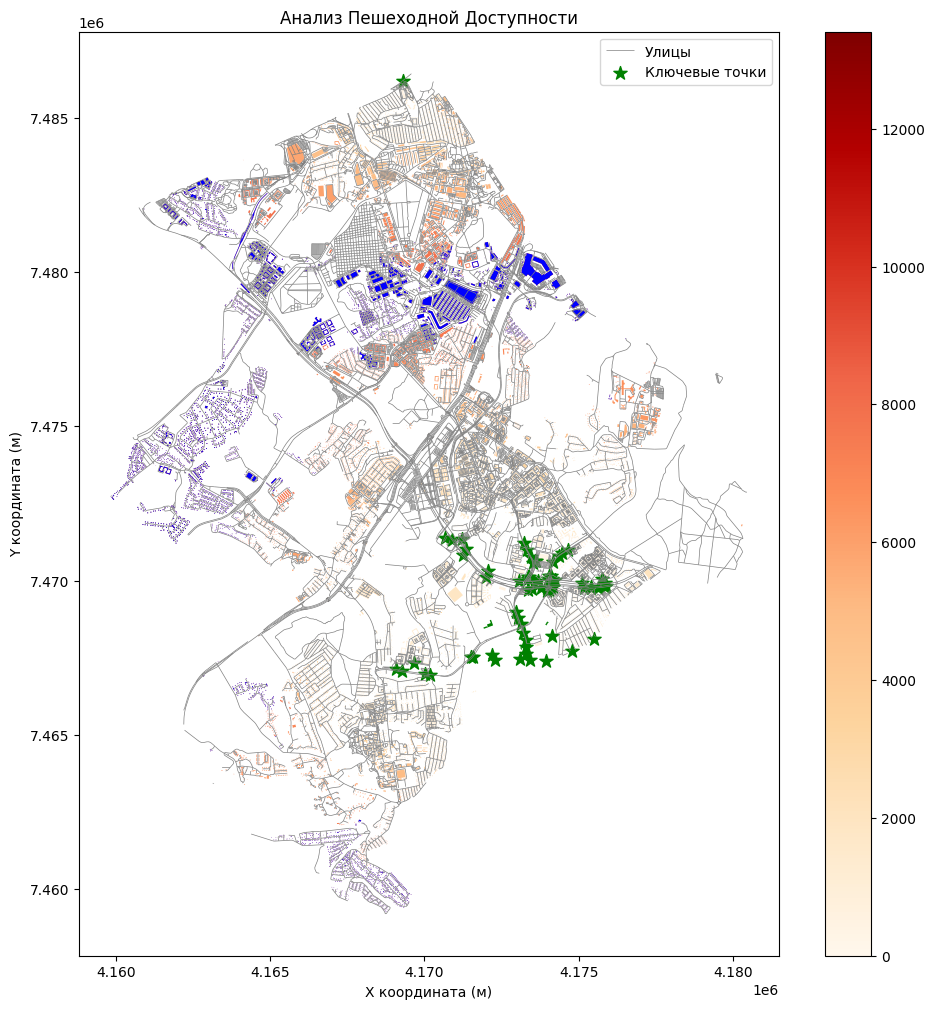

In [52]:
# --- Шаг 7: Визуализация Результатов ---
print("\nВизуализация результатов пешеходной доступности...")

# Определение порога для низкой доступности (например, верхние 25%)
threshold = houses_orig['accessibility'].quantile(0.75)
print(f"Порог для низкой доступности (75-й процентиль): {threshold}")

fig, ax = plt.subplots(figsize=(12, 12))

# Существующие улицы
streets_orig.plot(ax=ax, color='gray', linewidth=0.5, label='Улицы')

# Дома с доступностью
houses_orig.plot(ax=ax, column='accessibility', cmap='OrRd', markersize=50, legend=True, label='Доступность')

# Дома с низкой доступностью
low_access = houses_orig[houses_orig['accessibility'] > threshold]
low_access.plot(ax=ax, color='blue', markersize=50, label='Низкая доступность')

# Ключевые точки
key_points.plot(ax=ax, color='green', markersize=100, marker='*', label='Ключевые точки')

plt.legend()
plt.title("Анализ Пешеходной Доступности")
plt.xlabel("X координата (м)")
plt.ylabel("Y координата (м)")
plt.show()